# **🐍 Solving the Snake game using Reinforcement Learning 🤖**


Welcome to this hands-on tutorial! We are going to teach an AI agent to play the game of Snake from scratch. Our journey will start with very simple ideas and build up to a powerful, foundational Reinforcement Learning algorithm called **REINFORCE**.

Our approach will focus on directly learning a **policy**. A policy is essentially the agent's brain or strategy; it's a function that looks at the current state of the game and decides which action to take next. Instead of trying to calculate the value of every possible move, we'll teach our agent how to act directly.

**Learning Objectives:**

By the end of this practical, you will be able to:

*   ✅ **Define** what a policy is and explain its central role in RL.
*   🧠 **Implement** a simple "parameterised" policy that maps game observations to actions.
*   🎲 **Discover** the limitations of basic optimization by using random search to find a working policy.
*   📈 **Build** an intuitive understanding of why policy gradient methods are more effective.
*   🚀 **Implement** the classic REINFORCE algorithm from scratch to train a capable Snake-playing agent.

**Prerequisites:**

To get the most out of this tutorial, you should have some familiarity with:

* [Python](https://www.python.org/) and common libraries like [numpy](https://numpy.org/)
* [JAX](https://github.com/google/jax) for fast, numerical computing and automatic differentiation
* Basic Machine Learning concepts, such as model parameters (weights), gradients, and the softmax function



**Outline:**

>[🐍 Solving the Snake game using Reinforcement Learning 🤖](#scrollTo=m2s4kN_QPQVe)

>>[0. A Brief Overview of Reinforcement Learning](#scrollTo=JTn1nJDZG3XU)

>>>[Formalisms and RL flow](#scrollTo=YYPCT4jFHk5h)

>>[1. Our goal: learning a policy to play Snake](#scrollTo=WGYYZewoxoa1)

>>>[The Snake environment 🐍](#scrollTo=7pMY49EGs_bS)

>>>[Our starting point: a simple rule-based policy](#scrollTo=dIHv2xPouibI)

>>[2. Parameterised policies](#scrollTo=emHdjHmQx1rE)

>>>[✏️ Exercise: get logits from observation](#scrollTo=Jqc4ffwgx3Dn)

>>>[✏️ Exercise: sample action from logits](#scrollTo=70nNM8oryDxe)

>>[3. Random Policy Search](#scrollTo=UPMIzyY1yjQm)

>>>[The Random Search Loop](#scrollTo=2syU51URy4d6)

>>[4. Neural Networks as Policies](#scrollTo=_6qkkdRSGS0m)

>>[5. A Recap of Gradients](#scrollTo=73g8K5F5L9Jc)

>>>>[Finding the Gradient with JAX](#scrollTo=iFHcO4npMpO2)

>>[6. The Gradient of a Policy](#scrollTo=LSlkvjjSUYYN)



In [ ]:
# @title Install and import required packages.

%%capture
!pip install jumanji

from typing import NamedTuple

import jumanji
from jumanji.wrappers import JumanjiToGymWrapper
from jumanji.environments.routing.snake.types import Actions, State, Observation
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import flax.linen as nn

import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import display, Image
import io

from tqdm import notebook

## **0. A Brief Overview of Reinforcement Learning**

Reinforcement Learning (RL) is a field of Machine Learning (ML) where an agent learns **what to do** in a given situation by directly interacting with an environment. Rather than being taught with a labeled dataset, the agent learns from *experience*, that is, from the consequences of its actions, much like learning through *trial and error*.

> Think about how a person learns to ride a bike 🚴: you don't read a book of instructions (supervised learning); you get on the bike and learn from trial and error. Staying balanced is your reward, and falling over is your penalty. RL works on this same fundamental principle of learning from feedback.

**Why learn without labeled data?**

*   **For many problems, examples don't exist.** Creating a perfect, labeled dataset for complex control tasks is often impossible. Consider training a robot to navigate an unfamiliar building or an AI to master the intricate strategy of a game like StarCraft. In these cases, the only way to learn is by doing.
*    **It opens the door to superhuman performance.** An agent trained on human-provided examples is fundamentally limited by the performance of its human teacher. By learning through trial and error, an RL agent can discover novel strategies and achieve superhuman performance, finding solutions a human might never have imagined.

### **Formalisms and RL flow**

**How do we train models *without* labels?** To explain this, we need to introduce some key concepts in RL.

**Agents and Environments**

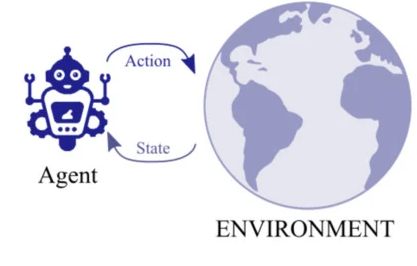


* **Agent:** The learner and decision-maker. The agent recieves **observations** from the environment and uses this information to choose how to act.

 > An agent could refer to a virtual agent like an AI model or a physical agent like a robot. In this practical, our agent is the AI we are training to control the snake 🐍.

* **Environment:** The world the agent lives in and the problem it tries to solve. The environment receives the agent's action, updates its state, and provides a **reward** and a new **observation** back to the agent.

 > In this practical, the environment is the Snake game itself, including the grid, the food, and the rules of movement 🌴.

The ultimate goal of the agent is to take actions that **maximize its cumulative reward over time**, much like achieving a high score in a video game.

**The RL workflow: a cycle of interaction**

An agent learns by repeatedly interacting with its environment. This interaction can be broken down into discrete moments called **timesteps**. At each timestep `t`, the following happens:


1.  The agent receives a view of the game state, called an **observation** (`o_t`).

2.  Based on this observation, the agent chooses an **action** (`a_t`).

3.  The environment processes the action and returns a **reward** (`r_t`) and a new observation (`o_{t+1}`).


This sequence of interactions forms the basis of all the experience the agent will learn from.

*   **Episode**: An episode is a single complete run of the task, from a starting state to a terminal state. In Snake, an episode is one full game, from the moment the snake appears until it crashes.

*   **Trajectory**: A trajectory is the complete record of one episode. You can think of it as a detailed replay of a game, logging every single observation, action, and reward in the order they happened.

 > A trajectory looks like this: `o_0, a_0, r_0, o_1, a_1, r_1, o_2, a_2, r_2, ...` until the episode ends.


**Thinking in the long term**


A crucial concept in RL is **sequential decision-making**. The agent's goal isn't just to get the highest immediate reward. An action that gives a small reward now might lead to a much larger reward later (like moving towards food instead of into a corner). **The agent must learn to make these kinds of strategic, long-term decisions.**

To do this, the agent needs to understand the key ingredients of the problem it's trying to solve:


*   **State**: A complete description of the environment at a single point in time.

    > In Snake, a state is the layout of the grid: the exact position of the snake's head and body, and the location of the food.

*   **Actions**: The set of all possible moves the agent can make.

    > In Snake, the possible actions are *UP, RIGHT, DOWN, LEFT*.

*   **Rewards**: The feedback signals (or scores) the environment provides. The agent's objective is to maximize the sum of these rewards.

    > In Snake, the agent gets a reward of +1 for eating food and 0 at all other times.

*   **The goal**: The agent's goal is to maximize the **cumulative discounted reward**. Instead of just summing the rewards, we often "discount" future rewards using a **discount factor** (gamma, or `γ`, with values between `0.0` and `1.0`). This encourages the agent to find rewards sooner rather than later and is a key part of making the math work for long-running episodes.

<!-- Previous version

An important concept to understand in RL is **sequential** decision making. The agent's goal isn't just to get the highest immediate reward, but to maximize its total reward over an entire **episode**. An action that gives a small reward now might lead to a much larger reward later, and the agent needs to learn to make those kinds of strategic, long-term decisions.

To formalize this, we use a mathematical framework called the **Markov Decision Process (MDP)**. The MDP is a way to describe the environment and the learning problem.

The MDP can be defined by the tuple `<S, A, P, R, γ>`, where:

*   **S (State Space)** - Represents all possible valid configurations of the environment.

    > *e.g., in Snake, a single state is the complete layout of the grid: the exact position of the snake's head and body, and the location of the food.*

*   **A (Action Space)** - All possible actions the agent can take.

    > *e.g., in Snake, the action space is the set of four moves: {UP, RIGHT, DOWN, LEFT}.*

*   **P (Transition Function)** - The rules of the environment. It defines the probability of transitioning to a new state `S'` given the current state `S` and an action `A`.

    > *e.g., in our simple Snake game, if the snake's head is at (5,5) and it takes the action RIGHT, the transition function dictates that its new head position will be (5,6) with 100% probability (unless a wall is there).*

*   **R (Reward Function)** - Generates a reward signal based on the state and action.

    > *e.g., in Snake, the reward function gives +1 for being in a state where the snake's head is on the food, and 0 for all other states.*

*   **γ (Discount Factor)** - A value between 0 and 1 that controls the importance of future rewards versus immediate rewards.

    > *A low γ makes the agent "short-sighted," caring mostly about the next immediate reward. A high γ (e.g., 0.99) makes the agent "far-sighted," encouraging it to plan for rewards far into the future, even if it means sacrificing a small immediate reward.*

By mapping an environment to this MDP tuple, we can then train an RL agent to solve it. During this practical you will do this with snake to train a superhuman agent.
-->


**Training and acting**

Unlike supervised learning where we have a fixed dataset, our RL agent generates its own training data. This happens in a loop that alternates between two distinct phases:

1.  **Acting (Data Collection)**: The agent interacts with the environment using its current **policy**. It plays many episodes of the game to explore and see what happens. We record all of these trajectories to create a batch of experience. This batch is our training data.

2.  **Training (Learning)**: In this phase, we pause the interaction. The agent analyzes the data it just collected. It looks at the trajectories and learns which actions led to good outcomes (high cumulative rewards) and which led to bad ones. Using this information, it updates its policy to make the "good" actions more likely in the future.

This loop is the core of most RL algorithms. The agent **acts** to gather data, then **trains** to improve its actions. The newly improved agent then acts again, gathering better data, which leads to even better training. This iterative cycle is how the agent goes from knowing nothing to playing the game with skill.

## **1. Our goal: learning a policy to play Snake**

Now that we've covered the core concepts of Reinforcement Learning, it's time to apply them. Our mission in this practical is to teach an agent to play the classic game of Snake from scratch. We won't use any complex deep learning models yet. Instead, we'll build our understanding from the ground up by focusing on the most fundamental component: **the policy**.

As we discussed, a **policy** is the agent's brain. It's the strategy that maps what an agent sees (**observation**) to what it does (**action**). Our entire goal is to find an optimal policy that guides the snake to eat as much food as possible and achieve the highest score by the end of its training.

### The Snake environment 🐍

Before our agent can learn, it needs a world to live in. This is the **environment** 🌴. We have created a simple, JAX-based Snake environment for you. You don't need to understand all the implementation details, but let's review its main components:

*   **Observation:** The observation is a dictionary containing:
    *   `grid`: A 3D grid representing the game board `(GRID_SIZE, GRID_SIZE, 5)`
    *   `step_count`: current number of steps in the episode.
    *   `action_mask`: array specifying which directions the snake can move in, without hitting a wall or itself, from its current position.
*   **Actions:** The agent can take one of four actions, represented by integers: `0` (UP), `1` (RIGHT), `2` (DOWN), `3` (LEFT).
*   **Rewards:** The agent receives a reward signal from the environment at each step:
    *   `+1` for eating food.
    *   `0` for every other step.

We use a simple grid-based Snake environment. Here's how we will create it with the `jumanji` library:
-->



In [ ]:
#@title Creating the environment.

GRID_SIZE = 5  # how big our grid will be
key = jax.random.PRNGKey(42)  # random seed

env = jumanji.make("Snake-v1", num_rows=GRID_SIZE, num_cols=GRID_SIZE)
env = JumanjiToGymWrapper(env)  # A friendly environment API

obs = env.reset()  # restart the environment
random_action = env.action_space.sample()  # generate a random action
obs, reward, term, trunc, info = env.step(random_action)  # take a single step in the environment

<!--
Let's break down the core concepts using our Snake game:

*   **Agent 🧠:** The agent is the decision-maker. In our case, it's the "brain" that controls the snake. Its goal is to get the highest score possible.
*   **Environment 🌍:** The environment is the world the agent interacts with. Here, it's the game of Snake itself, including the board, the food, and the rules (like dying if you hit a wall).
*   **State (s) 📊:** Holds the underlying dynamics of the environment that are
use to simulate it. This is not visible to the agent
*   **Observation (o) 👀:** What the agent sees in the environment and can use to choose its action.
*   **Action (a) 🕹️:** An action is a choice the agent can make from a given state. Our snake can choose one of four actions: UP, RIGHT, DOWN, or LEFT.
*   **Reward (r) 🎁:** A reward is a signal from the environment that tells the agent how well it's doing. Our snake gets a positive reward for eating food. This feedback is what the agent uses to learn.
*   **Episode 🎬:** An episode is a full sequence of interactions from a starting state to a terminal state (like game over). In Snake, one full game is one episode.

**The policy (π): the agent's brain**

So, how does the agent decide which action to take in a given state? This is where the **policy** comes in.

> 🎯 **Definition: Policy (π)**
> A policy is the agent's strategy or decision-making mechanism. It's a function that maps a state to an action (or a probability distribution over actions).
>
> **π(action | state) = Probability of taking `action` in `state`**

Our ultimate goal in RL is to find an **optimal policy (π\*)** — a policy that maximizes the total cumulative reward over an episode.
-->

### Our starting point: a simple rule-based policy

A policy doesn't have to be a complex, learned neural network. At its core, it's just a set of rules for choosing an action based on an observation. To get a feel for how policies work and to establish a baseline for our agent's performance, let's start by creating a simple policy using hand-written rules.

In [ ]:
#@title Simple implementation of a rule-based policy.

# The state holds the underlying dynamics of the environment. A real policy
# would use the agent's observation, but we use the state here for simplicity.

def rule_based_policy(state: State) -> int:
  """A simple, non-optimal rule-based policy for the Snake game.

  This policy calculates the vector from the snake's head to the food and
  chooses the action that moves along the largest axis of that vector.
  It deliberately ignores obstacles and is intended as a simple baseline.

  Args:
      state: The full environment state, containing head and food positions.

  Returns:
      The integer representing the chosen action (UP, DOWN, LEFT, or RIGHT).
  """
  # Calculate the vector from the snake's head to the food.
  dx = state.fruit_position.col - state.head_position.col
  dy = state.fruit_position.row - state.head_position.row

  action = Actions.UP  # Default action.

  # Choose the primary axis of movement (vertical or horizontal).
  # Note: we don't check for collisions, so this policy is not optimal!
  # If you want, you can try and make sure that the next position
  # will not collide with the walls or the body of the snake.
  if abs(dy) > abs(dx):
    # Move vertically.
    if dy < 0:
      action = Actions.UP
    else:
      action = Actions.DOWN
  else:
    # # Move horizontally.
    if dx < 0:
      action = Actions.LEFT
    else:
      action = Actions.RIGHT

  return action

**Evaluating the policy**

Now that we have a policy, how good is it?

We can find out by running it for a full episode and summing up the rewards. Let's create a helper function to do this.

In [ ]:
#@title Unroll episode.

def play_episode(policy_fn, max_steps: int = 100) -> tuple[float, list]:
    """Plays one episode of Snake using a given policy function.

    This function relies on a globally defined `env` object. It runs a loop,
    calling the policy at each step, and collects the total reward and a
    sequence of states for later animation.

    Args:
        policy_fn: A function that accepts the environment's internal state
            and returns an integer action.
        max_steps: The maximum number of steps to run the episode for, to
            prevent infinite loops.

    Returns:
        A tuple containing:
        - total_reward: The sum of rewards collected during the episode.
        - frames: A list of the environment's state objects from each step.
    """
    obs = env.reset()
    state = env._state
    total_reward = 0.0
    done = False

    # Store the state at each step to create an animation later.
    frames = []

    for i in range(max_steps):
        if done:
            break

        # Note: We are passing the internal `env._state` to the policy.
        # This is a simplification for our simple rule-based policy.
        # More advanced agents would use the `observation` (obs) instead.
        action = policy_fn(env._state)

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # NOTE: there's currently a bug in jumanji that's been fixed, I just haven't released it to pip yet.
        total_reward += reward
        frames.append(env._state)

    return total_reward, frames

Now, let's see how our simple policy performs in a single episode. We can run our `play_episode` function and print the total reward, which corresponds to the number of fruit the snake eats.


In [ ]:
total_reward, frames = play_episode(rule_based_policy)

print(f"The rule-based policy ate {int(total_reward)} fruit")

The rule-based policy ate 6 fruit


A score is good, but seeing the policy's behavior gives us more insight. Let's animate the episode to see what our agent did.

In [ ]:
# @title Animate the episode
env._env.animate(frames)

You can see that this rule-based policy is a good start! But as we mentioned, it has a major flaw: **it doesn't account for obstacles.** It will happily run straight into its own body if that's the shortest path to the food.

**The problem with a hand-crafted policy**

We could try to improve our policy by adding more rules: "if an obstacle is directly ahead, try turning left," "if left is blocked, try turning right," and so on. But this process of adding exceptions and complex logic quickly becomes unmanageable and brittle.

This is the fundamental limitation of trying to "program" intelligence. A truly smart agent should be able to learn the rules on its own.

**The path forward: learning a policy**

Instead of trying to write a perfect set of rules ourselves, what if we could define a flexible policy and have an algorithm discover the *best settings* automatically?

This is the core idea behind modern Reinforcement Learning. In the next sections, we will:
1.  Create a **parameterized policy** whose behavior can be changed by tweaking its numbers (parameters).
2.  Use an optimization algorithm to **learn** the best parameter values directly from playing the game.


## **2. Parameterised policies**



Instead of hand-crafting `if/else` rules, we can define our policy as a mathematical function whose behavior is controlled by a set of **parameters (θ)**.

For our Snake game, the observation is the `(GRID_SIZE, GRID_SIZE)` grid. The simplest way to use this is to:
1.  **Flatten** the grid into a long vector of size `GRID_SIZE * GRID_SIZE`.
2.  Perform a **linear transformation** on this vector.

Our policy will take the flattened observation vector and multiply it by a weight matrix `θ` to produce **four numbers**, which we call **logits**. Each logit corresponds to one action (UP, RIGHT, DOWN, LEFT).

`logits = observation_vector @ θ`

The higher the logit, the more the policy "prefers" that action.

To make a final decision, we convert these logits into a probability distribution using the **softmax** function and then **sample** one action from it. Sampling (instead of just picking the highest logit) allows for **exploration**, letting the agent try out actions that might not seem optimal at first but could lead to better outcomes later.

### ✏️ **Exercise: get logits from observation**

Let's implement the first part: the linear transformation. Your task is to complete the `get_logits` function.

**Hints:**
*   The `params` (our `θ`) will have the shape `(input_size, num_actions)`. For our `5x5` grid, `input_size` is 25 and `num_actions` is 4.
*   First, flatten the `obs` grid into a 1D vector. You can use `obs.flatten()`.
*   Then, perform a matrix multiplication between the flattened observation and the parameters. The `@` operator is used for matrix multiplication.

In [ ]:
def get_logits(params: jnp.ndarray, obs: jnp.ndarray) -> jnp.ndarray:
    """Calculates the logits for each action given observation and parameters.

    Args:
        params: The policy parameters (theta), shape (input_size, num_actions).
        obs: The observation grid, shape (grid_size, grid_size).

    Returns:
        A 1D array of logits, shape (num_actions,).
    """
    # --- YOUR CODE HERE ---
    # Step 1: Flatten the observation grid.

    # Step 2: Multiply the flattened observation by the parameters.

    # ----------------------

    return  # return your logits

In [ ]:
#@title Solution

def get_logits(params: jnp.ndarray, obs: jnp.ndarray) -> jnp.ndarray:
    """
    Calculates the logits for each action given an observation and parameters.

    Args:
        params: The policy parameters (theta), shape (input_size, num_actions).
        obs: The observation grid, shape (grid_size, grid_size).

    Returns:
        A 1D array of logits, shape (num_actions,).
    """
    # --- YOUR CODE HERE ---
    # Step 1: Flatten the observation grid.
    obs_flat = obs.flatten()

    # Step 2: Multiply the flattened observation by the parameters.
    logits = obs_flat @ params
    # ----------------------

    return logits  # return your logits

### ✏️ **Exercise: sample action from logits**

Now that we have logits, we need to sample an action. We'll use JAX's `random.categorical` function. This function takes a set of logits, internally converts them to probabilities (using softmax), and samples from the resulting distribution.

Your task is to complete the `sample_action` function.

In [ ]:
def sample_action(key: jax.random.PRNGKey, logits: jnp.ndarray) -> int:
    """Samples an action from a categorical distribution defined by the logits.

    Args:
        key: A JAX random key.
        logits: A 1D array of logits for each action.

    Returns:
        A single integer representing the chosen action.
    """
    # --- YOUR CODE HERE to sample an action ---

    # ----------------------

    return   # return your action

In [ ]:
#@title Solution

def sample_action(key: jax.random.PRNGKey, logits: jnp.ndarray) -> int:
    """
    Samples an action from a categorical distribution defined by the logits.

    Args:
        key: A JAX random key.
        logits: A 1D array of logits for each action.

    Returns:
        A single integer representing the chosen action.
    """
    # --- YOUR CODE HERE to sample an action ---
    action = jax.random.categorical(key, logits)
    # ----------------------

    return action  # return your action

Now we can combine these two functions into a complete parameterised policy.

In [ ]:
#@title Parameterised policy using previous functions

def parameterised_policy(
    params: jnp.ndarray, obs: jnp.ndarray, key: jax.random.PRNGKey
) -> jnp.ndarray:
    """Computes an action using the full parameterized policy.

    This function performs 2 main steps:
    1. Calculating action scores (logits) from the observation and parameters.
    2. Randomly sampling an action from those logits using a random key.

    Args:
        params: The weight matrix (theta) of the policy.
        obs: The observation from the environment.
        key: A JAX random key for enabling stochastic sampling.

    Returns:
        A JAX array containing the integer for the chosen action.
    """
    # Note: `get_logits` and `sample_action` should have been implemented above.
    logits = get_logits(params, obs)
    action = sample_action(key, logits)
    return action

Let's try it out. First, we need some random parameters.

In [ ]:
# The shape is (input_size, num_actions).
INPUT_SIZE = GRID_SIZE * GRID_SIZE * 5
NUM_ACTIONS = 4
key, params_key = jax.random.split(key)

# These are our initial, random parameters theta.
random_params = jax.random.normal(params_key, (INPUT_SIZE, NUM_ACTIONS))

Now, let's see what action our untrained policy takes.

In [ ]:
action_map = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}

key, action_key = jax.random.split(key)
action = parameterised_policy(random_params, obs['grid'], action_key)

print(f"Our new parameterised policy (with random parameters) chose: {action_map[int(action)]}")

Great! We now have a flexible policy defined by a matrix of weights `θ`.

The question now is: how do we find good values for `θ`? This is the job of a learning algorithm.

## **3. Random Policy Search**

Let's start with the simplest possible learning algorithm: **random search**.

The idea is a straightforward "guess-and-check" approach:
1.  Create a bunch of random parameter sets (`θ`).
2.  For each set, play a game and see what the total reward is.
3.  Keep the parameter set that achieved the highest reward.

This brute-force method is not very efficient, especially as the number of parameters grows. However, it's a valid algorithm and a fantastic way to build intuition. We are literally searching for a single good solution within the vast "parameter space" of our policy.

To implement this search, we first need a helper function that can generate one set of random parameters `θ`.

In [ ]:
def sample_random_policy_params(
    key: jax.random.PRNGKey,
    input_size: int,
    num_actions: int,
  ) -> jnp.ndarray:
  """Generates a random set of parameters (theta) for our linear policy.

  Args:
      key: A JAX random key.
      input_size: The size of the flattened observation vector.
      num_actions: The number of possible actions.

  Returns:
      A JAX array of parameters with shape (input_size, num_actions).
  """
  param_shape = (input_size, num_actions)
  params = jax.random.normal(key, param_shape)
  return params


### The Random Search Loop

Now we can write the main loop for our algorithm. We will also need to update our `play_episode` function slightly to work with our new policy structure.

In [ ]:
def play_episode_parameterised(params, key, max_steps=100):
  """
  Plays one episode using a parameterised policy.
  This version handles the key splitting required for JAX.
  """
  total_reward = 0.0
  frames = []

  # The state itself contains a key for JAX's random functions
  obs, _ = env.reset()
  done = False  # to start with we are not done
  frames.append(env._state)


  while not done:
    # Split key for this step's action and for the next state
    key, action_key = jax.random.split(key)

    # Get action from our parameterised policy
    action = parameterised_policy(params, obs["grid"], action_key)

    obs, reward, done, _, _ = env.step(action)

    # Record the reward and frames so we can check which is the best policy
    # and visualize it.
    total_reward += reward
    frames.append(env._state)

  return total_reward, frames

Now let's run this in a loop!

In [ ]:
#@title Random Search: main loop

num_trials = 200 #@param

best_reward = -jnp.inf
best_params = None
best_frames = None

print(f"🔥 Starting random search with {num_trials} trials...")

for i in range(num_trials):
  # Get a new key for this trial.
  key, trial_key, episode_key = jax.random.split(key, 3)

  # Sample a new set of random parameters.
  current_params = sample_random_policy_params(trial_key, INPUT_SIZE, NUM_ACTIONS)

  # Evaluate these parameters by playing an episode.
  # We use the same initial_state for a fair comparison.
  current_reward, frames = play_episode_parameterised(current_params, episode_key)

  # If they are the best so far, save them.
  if current_reward > best_reward:
    best_reward = current_reward
    best_params = current_params
    best_frames = frames
    print(f"Trial {i+1}/{num_trials} | New best reward: {best_reward:.2f}")

print("\n🎉 Search complete!")
print(f"The best policy we found achieved a reward of: {best_reward:.2f}")

Let's see the best policy in action!

Now for the moment of truth. Let's take the `best_params` we found and watch the agent play. Is it any good?

In [ ]:
#@title Play best episode.
env._env.animate(best_frames)

Hopefully, you see a snake that is behaving slightly better than a purely random one! It might not be perfect, but it has "learned" a strategy by simply trying many random things and remembering what worked best 😅. It's likely worse than the **rule-based policy** policy we saw earlier.

**Summary so far:**

1.  We defined the core concepts of RL -- **agent**, **environment**, **policy** -- in the context of the Snake game.
2.  We saw the limitations of a **rule-based policy**.
3.  We defined a flexible, **parameterised policy** using a simple linear function.
4.  We implemented our first **learning algorithm**, Random Search, to find good parameters for our policy.

This is just the beginning of the journey. While Random Search is simple and intuitive, it's not very efficient for complex problems. The field of RL has developed far more powerful, gradient-based algorithms (like **REINFORCE**, A2C, PPO) that "climb the hill" of rewards much more intelligently than just jumping around randomly.

You now have the conceptual foundation to explore these more advanced topics. Well done! 👏

## **4. Neural Networks as Policies**

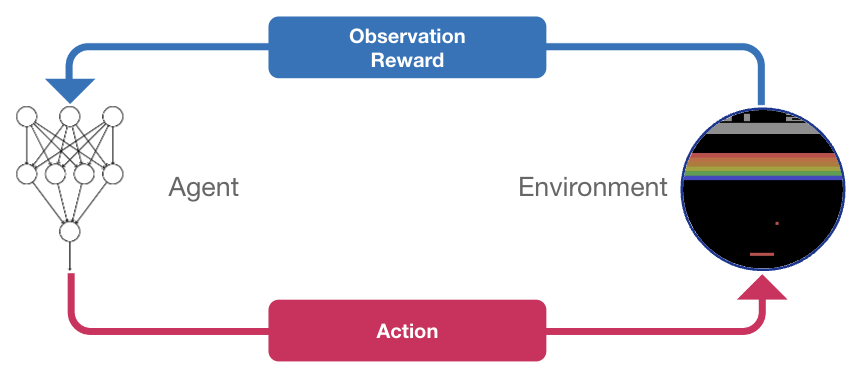

So far, we've used a simple linear function to map our game observations directly to action logits:
```
f(θ, observation) = observation @ parameters -> logits
```

This is a good start, but it's quite limited. It can only learn simple linear relationships, but the logic required to win a game of Snake is often far more complex. For instance, how do you represent the idea: "If the food is to my left, but my own tail is also there, I should go up instead"? 🤔

We need a more powerful function that can learn these complex, non-linear strategies. A Neural Network is the perfect tool for this job! 🧠

A neural network is simply a function that can approximate complex relationships between an input and an output. We can use it as our policy, where the network's weights are our parameters (`θ`). The network will take the game state as input and output the logits for each possible action. The function
definition is identical to the simple linear function, except the operation is
more complex than `observation @ parameters`:
```
f(θ, observation) = logits
```

For this practical, we'll use **Flax**, a popular neural network library for JAX. We'll briefly introduce some key concepts:

**Layers:** These are the building blocks of a network. A `Dense` layer is the standard fully connected layer. By stacking these layers, we can build a Multi-Layer Perceptron (MLP)

In [ ]:
width = 8
fully_connected_layer = nn.Dense(width)

**Activation functions:** If we only use dense layers the network won't be able to model complex, non-linear behaviours. To achieve this we use functions such as relu/tanh/sigmoid after each dense layer.

In [ ]:
jax.nn.relu

**Modules:** flax modules are classes that allow us to stitch together different layers and activation functions.

In [ ]:
class MyNeuralNetwork(nn.Module):
  def setup(self):
    self.fully_connected_layer = nn.Dense(8)
    self.output_layer = nn.Dense(5)

  def __call__(self, data: jax.Array):
    hidden = self.fully_connected_layer(data)
    hidden = jax.nn.relu(hidden)
    output = self.output_layer(hidden)

    return output

**Initialization:** To create initial parameters in Flax we pass a dummy version of our input into the network so that flax can work out the size of the matrices


In [ ]:
dummy_input = jnp.zeros(5)  # An array of 5 zeros
real_input = jnp.ones(5)  # and array of 5 ones
key = jax.random.key(0)  # a key to randomly initialize the parameters

net = MyNeuralNetwork()  # create our network
parameters = net.init(key, dummy_input)  # initialise the network parameters
net.apply(parameters, real_input)  #

**Exercise:** Define a simple MLP using Flax. This network will be our new policy.

Requirements:
* Two hidden `Dense` layers
* Hidden layer width of 32
* A final Dense layer to produce the 4 action logits.
* Each hidden layer should be followed by a `relu` function.

In [ ]:
class Policy(nn.Module):
  def setup(self):
    ...

  def __call__(self, observation):
    ...

In [ ]:
#@title Solution
class Policy(nn.Module):
  def setup(self):
    self.layer_1 = nn.Dense(32)
    self.layer_2 = nn.Dense(32)
    self.output_layer = nn.Dense(4)

  def __call__(self, observation):
    hidden = self.layer_1(observation)
    hidden = jax.nn.relu(hidden)
    hidden = self.layer_2(observation)
    hidden = jax.nn.relu(hidden)
    logits = self.output_layer(hidden)

    return logits


## **5. A Recap of Gradients**

Now that we have a powerful policy, how do we train it? We can't just try random parameters anymore, we saw that this doesn't work very well. We need a smarter way to update our parameters to improve the policy. The key to this is the gradient. 🔑

Imagine you're a hiker standing on the side of a mountain in thick fog, and your goal is to get to the highest peak (i.e., maximize your reward). You can't see the peak, but you can feel the slope of the ground right where you are. The direction of the steepest slope upwards is your gradient. If you take a small step in that direction, you'll gain altitude. ⛰

In reinforcement learning:
The mountain is our *reward landscape*. Every possible set of policy parameters (`θ`) has an associated expected reward.
Our position on the mountain is the current set of parameters for our policy.

The gradient (`∇ θ`) is a vector that points in the direction of the steepest ascent in reward. It tells us precisely how to adjust each individual parameter in our neural network to achieve the greatest increase in our policy's performance.
By calculating this gradient, we can "nudge" our policy's parameters in the direction that makes it better. This process of following the gradient to maximize our reward is called gradient ascent.


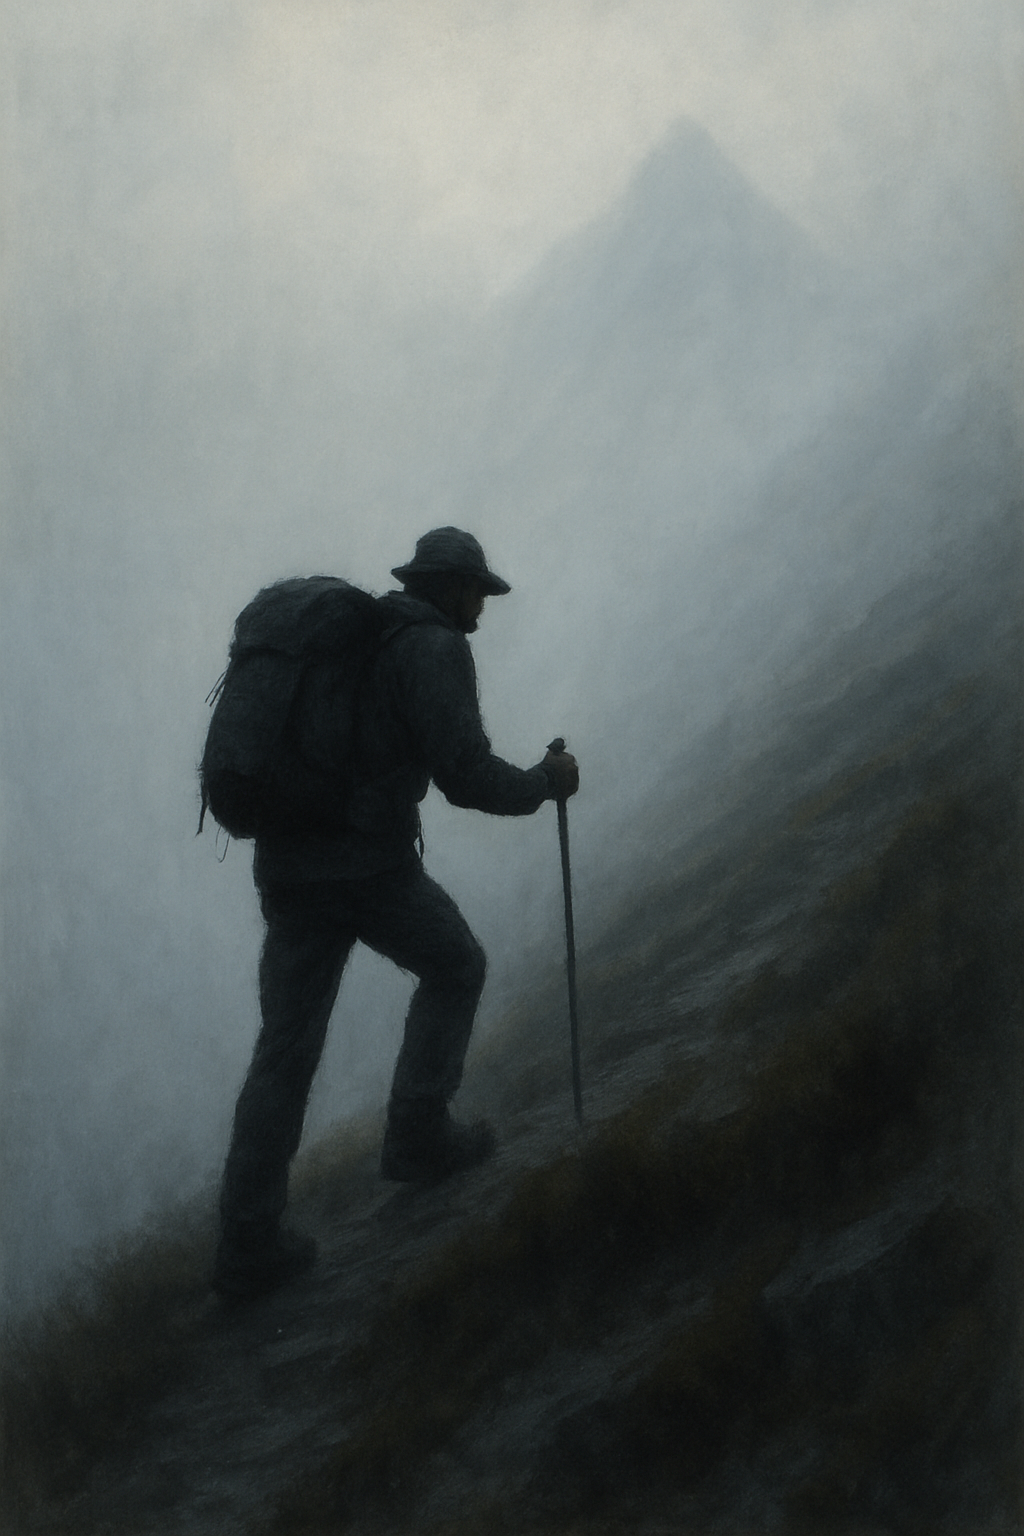

#### Finding the Gradient with JAX

Calculating these gradients for a massive neural network by hand would be impossible. Thankfully, automatic differentiation libraries like JAX do it for us!

Here's an example of taking the gradient of the simple equation

```
f(x) = x^2 + 2x + 5
```

In [ ]:
def f(x):
  return x ** 2 + 2*x + 5

grad_f = jax.grad(f)

Now `grad_f` is equivalent to

```
f'(x) = 2x + 2
```

So if we evaluate `f'(x)` at `3` we should get `8` 👀

In [ ]:
float(grad_f(3.0))

JAX can do this for any function, even the neural network function we defined earlier `f(θ, observation) = logits`. But how can we use this gradient to update our policy? 🤔


## **6. The Gradient of a Policy**

To climb the mountain, we first need to define how "good" a particular policy $\pi_\theta$ is.
For this, we will define the following "expected return" function, where $J(\theta)$ computes how much total return we should expect a policy with parameters $\theta$ to obtain:

\begin{align*}
\underset{\text{Expected return}}{J(\theta)} &=
\sum_{\underset{\text{All states}}{s \in S}}
\underset{\begin{array}{c}\text{Stationary distribution} \\ \text{under policy } \pi\end{array}}{d^{\pi}(s)} \,
\underset{\begin{array}{c}\text{Value of state } s \\ \text{under policy } \pi\end{array}}{V^{\pi}(s)} \\
&=
\sum_{s \in S}
d^{\pi}(s)
\sum_{\underset{\text{All actions}}{a \in A}}
\underset{\begin{array}{c}\text{Probability of taking action } a \\ \text{in state } s \text{ under } \pi_\theta\end{array}}{\pi_{\theta}(a \mid s)} \,
\underset{\begin{array}{c}\text{Expected return for } a \text{ in } s \\ \text{under policy } \pi\end{array}}{Q^{\pi}(s, a)}
\end{align*}

The value $V^{\pi}(s)$ comes from the total reward you expect to get when you follow the policy $\pi$, startung from the state $s$.
Similarly, $Q^{\pi}(s, a)$ is the total reward you expect to get when you take action $a$ in state $s$ and then keep following the policy $\pi$.

$d^\pi(s)$ is a bit more complex: it represents the long-term probability of being in state $s$ when you following the policy $\pi$.

For example, consider a simple policy in a 2x2 world, where you always start in the top left state.
So at the start, the probability of being there is 1 and everywhere else has a probability of 0.
We keep executing the policy, updating the probability of where we could be.
Let's see what happens as we increase the number of steps (by dragging the slider).

In [ ]:
#@title Run Simulation

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# --- Define transition matrix for 2x2 grid world ---
P = np.array([
    [0.5, 0.5, 0.0, 0.0],
    [0.2, 0.3, 0.5, 0.0],
    [0.0, 0.3, 0.4, 0.3],
    [0.0, 0.0, 0.6, 0.4]
])

# --- Simulate the chain over time ---
d = np.array([1.0, 0.0, 0.0, 0.0])  # initial distribution
distributions = [d.copy()]
for _ in range(100):
    d = d @ P
    distributions.append(d.copy())

# --- Function to plot a 2x2 grid ---
def plot_distribution(step):
    grid = distributions[step].reshape(2, 2)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, cmap='Blues', vmin=0, vmax=1)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{grid[i, j]:.2f}", ha='center', va='center', color='black', fontsize=12)
    plt.title(f"Step {step}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# --- Create interactive slider ---
slider = widgets.IntSlider(value=0, min=0, max=15, step=1, description='Step:')
widgets.interact(plot_distribution, step=slider)


interactive(children=(IntSlider(value=0, description='Step:', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.plot_distribution(step)>

Notice how after 10 steps, the distribution stops changing - this is $d^\pi$.
Before we continue, let's try compute $J(\theta)$ ourselves.

In [ ]:
#@title Run Simulation

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- State transition matrix for 2x2 grid world (fixed) ---
P_base = np.array([
    [0.5, 0.5, 0.0, 0.0],
    [0.2, 0.3, 0.5, 0.0],
    [0.0, 0.3, 0.4, 0.3],
    [0.0, 0.0, 0.6, 0.4]
])

# --- Reward vector: only bottom-left state (state 2) gives reward 1 ---
rewards = np.array([0.0, 0.0, 1.0, 0.0])

# --- Define interactive sliders for policy parameters ---
theta0 = widgets.FloatSlider(value=0.5, min=0, max=1.0, step=0.01, description='theta_0:')
theta1 = widgets.FloatSlider(value=0.5, min=0, max=1.0, step=0.01, description='theta_1:')

def run_simulation(theta0_val, theta1_val):
    clear_output(wait=True)

    # Define a policy-dependent transition matrix as a convex combination
    # Here we interpolate between two fixed transition matrices for illustration
    # In real cases, policy affects action selection, which affects transitions

    # Create a modified transition matrix using theta0 and theta1
    P = P_base.copy()
    P[0] = theta0_val * np.array([1, 0, 0, 0]) + (1 - theta0_val) * P_base[0]
    P[1] = theta1_val * np.array([0, 0, 1, 0]) + (1 - theta1_val) * P_base[1]

    # Normalize rows to ensure valid probabilities
    P = P / P.sum(axis=1, keepdims=True)

    # --- Compute stationary distribution by iterating the chain ---
    d = np.array([1.0, 0.0, 0.0, 0.0])
    for _ in range(100):
        d = d @ P

    # --- Compute expected return J(θ) ---
    J = np.dot(d, rewards)

    # --- Plot final stationary distribution ---
    grid = d.reshape(2, 2)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, cmap='Blues', vmin=0, vmax=1)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{grid[i, j]:.2f}", ha='center', va='center', color='black', fontsize=12)
    plt.title(f"Stationary distribution\nExpected Return J(θ) = {J:.4f}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# --- Display interactive UI ---
ui = widgets.HBox([theta0, theta1])
out = widgets.interactive_output(run_simulation, {'theta0_val': theta0, 'theta1_val': theta1})
display(ui, out)


Output()

Great, now we have $J(\theta)$, a way to determine how good our policy $\pi_\theta$ with parameters $\theta$ is.
This is what we need to compute the gradient of, so we can climb the hill.
We need $\nabla_\theta J(\theta)$.
However, computing $d^\pi$ exactly so we can calculate its gradient totally impractical in non-toy environments.

This is where we can use a sneaky trick, called the "Policy Gradient Theorem".
Don't worry about the details: you can read about them in Section 13.1 of [Sutton and Barto, 2017](http://incompleteideas.net/book/bookdraft2017nov5.pdf), if you would like.
For our purposes, it proves the following:

\begin{align*}
\nabla_\theta J(\theta)
&= \color{red}{\nabla_\theta} \sum_{s \in {S}} d^\pi(s) \sum_{a \in {A}} Q^\pi(s, a)\, \pi_\theta(a \mid s) \\
&\propto \sum_{s \in {S}} d^\pi(s) \sum_{a \in {A}} Q^\pi(s, a)\, \color{red}{\nabla_\theta} \, \pi_\theta(a \mid s)
\end{align*}

This means that when computing our gradient $\nabla_\theta J(\theta)$, we only have to compute the gradient $\nabla_\theta \pi_\theta(a \mid s)$, which is the gradient of our policy (note that $\propto$ just means "is proportional to").

Simplifying this further, we get:

$\nabla_\theta J(\theta)
\propto \mathbb{E}_{\pi_\theta} \left[ Q^\pi(s, a) \, \nabla_\theta \log \pi_\theta(a \mid s) \right]$.

I.e., we have:

$$\underset{\text{Gradient of expected return}}{\nabla_\theta J(\theta)}
\propto
\underset{\text{Expected value over policy}}{\mathbb{E}_{\pi_\theta}}
\left[
\underset{\text{Value of action}}{Q^\pi(s, a)} \cdot
\underset{\text{Gradient of the policy}}{\nabla_\theta \log \pi_\theta(a \mid s)}
\right]$$